In [2]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Last week imports

In [3]:
def compute_loss(y, tx, w):
    """Calculate the loss.

    You can calculate the loss using mse or mae.
    """
    return sum((y - tx.dot(w))**2) / (2.0 * len(y))

In [4]:
def least_squares(y, tx):
    """calculate the least squares solution."""
    w = np.linalg.lstsq(tx, y, rcond=None)[0]
    return compute_loss(y, tx, w), w

In [5]:
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    poly = []
    for x_i in x:
        poly.append(np.power(np.repeat(x_i, degree + 1), range(degree + 1)))
    return np.array(poly)

In [6]:
from plots import *

def polynomial_regression():
    """Constructing the polynomial basis function expansion of the data,
       and then running least squares regression."""
    # define parameters
    degrees = [1, 3, 7, 12]
    
    # define the structure of the figure
    num_row = 2
    num_col = 2
    f, axs = plt.subplots(num_row, num_col)

    for ind, degree in enumerate(degrees):
        poly = build_poly(x, degree)
        loss, weights = least_squares(y, poly)
        rmse = np.sqrt(2 * loss)

        print("Processing {i}th experiment, degree={d}, rmse={loss}".format(
              i=ind + 1, d=degree, loss=rmse))
        # plot fit
        plot_fitted_curve(
            y, x, weights, degree, axs[ind // num_col][ind % num_col])
    plt.tight_layout()
    plt.savefig("visualize_polynomial_regression")
    plt.show()

In [7]:
def split_data(x, y, ratio, seed=1):
    """
    split the dataset based on the split ratio. If ratio is 0.8 
    you will have 80% of your data set dedicated to training 
    and the rest dedicated to testing
    """
    # set seed
    np.random.seed(seed)
    data_size = x.shape[0]
    training_indices = np.random.choice(data_size, int(data_size * ratio), replace=False)
    test_indices = np.delete(np.array(range(data_size)), training_indices) 
    return x[training_indices], y[training_indices], x[test_indices], y[test_indices]

In [8]:
def train_test_split_demo(x, y, degree, ratio, seed):
    """polynomial regression with different split ratios and different degrees."""
    train_x, train_y, test_x, test_y = split_data(x, y, ratio, seed)
    train_tx, test_tx = build_poly(train_x, degree), build_poly(test_x, degree)
    train_mse, train_w = least_squares(train_y, train_tx)
    test_mse = compute_loss(test_y, test_tx, train_w)
    rmse_tr, rmse_te = np.sqrt(2*train_mse), np.sqrt(2*test_mse)
    print("proportion={p}, degree={d}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
          p=ratio, d=degree, tr=rmse_tr, te=rmse_te))

In [9]:
def ridge_regression(y, tx, lambda_):
    """implement ridge regression."""
    A = tx.T.dot(tx)
    I = np.identity(A.shape[0])
    w = np.linalg.solve(A + lambda_ * 2 * len(y) * I, tx.T.dot(y))
    return compute_loss(y, tx, w), w

In [10]:
def ridge_regression_demo(x, y, degree, ratio, seed):
    """ridge regression demo."""
    # define parameter
    lambdas = np.logspace(-5, 0, 15)
    x_tr, y_tr, x_te, y_te = split_data(x, y, ratio, seed)
    poly_tr = build_poly(x_tr, degree)
    poly_te = build_poly(x_te, degree)

    rmse_tr = []
    rmse_te = []
    for ind, lambda_ in enumerate(lambdas):
        loss_tr, w_tr = ridge_regression(y_tr, poly_tr, lambda_)
        loss_te = compute_loss(y_te, x_te, w_tr)
        rmse_tr.append(np.sqrt(2 * loss_tr))
        rmse_te.append(np.sqrt(2 * loss_te))
        print("proportion={p}, degree={d}, lambda={l:.3f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
               p=ratio, d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))
        
    # Plot the obtained results
    plot_train_test(rmse_tr, rmse_te, lambdas, degree)

# Cross-Validation and Bias-Variance decomposition
## Cross-Validation
Implementing 4-fold cross-validation below:

In [11]:
from helpers import load_data

# load dataset
x, y = load_data()

In [12]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

In [13]:
from costs import compute_mse
from ridge_regression import ridge_regression
from build_polynomial import build_poly

def cross_validation(y, x, k_indices, k, lambda_, degree):
    """return the loss of ridge regression."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # get k'th subgroup in test, others in train: TODO
    # ***************************************************
    test_y, test_x = y[k_indices[k]], x[k_indices[k]]
    train_y, train_x = y[np.delete(k_indices, k, 0).flatten()], x[np.delete(k_indices, k, 0).flatten()]
    
    # ***************************************************
    # INSERT YOUR CODE HERE
    # form data with polynomial degree: TODO
    # ***************************************************
    test_tx, train_tx = build_poly(test_x, degree), build_poly(train_x, degree)
    
    # ***************************************************
    # INSERT YOUR CODE HERE
    # ridge regression: TODO
    # ***************************************************
    train_loss, train_w = ridge_regression(train_y, train_tx, lambda_)
    
    # ***************************************************
    # INSERT YOUR CODE HERE
    # calculate the loss for train and test data: TODO
    # ***************************************************
    test_loss = compute_mse(test_y, test_tx, train_w)
    
    return np.sqrt(2 * train_loss), np.sqrt(2 * test_loss)

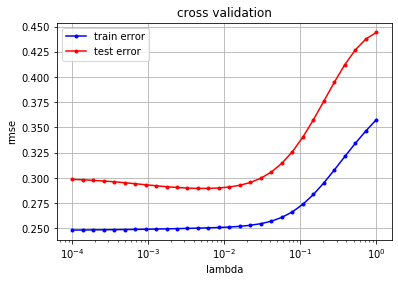

In [14]:
from plots import cross_validation_visualization

def cross_validation_demo():
    seed = 1
    degree = 7
    k_fold = 4
    lambdas = np.logspace(-4, 0, 30)
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    # ***************************************************
    # INSERT YOUR CODE HERE
    # cross validation: TODO
    # ***************************************************
    for lambda_ in lambdas:
        total_rmse_tr, total_rmse_te = 0, 0
        for k in range(k_fold):
            rmse_train, rmse_test = cross_validation(y, x, k_indices, k, lambda_, degree)
            total_rmse_tr += rmse_train
            total_rmse_te += rmse_test
        rmse_tr.append(total_rmse_tr / k_fold)
        rmse_te.append(total_rmse_te / k_fold)
    cross_validation_visualization(lambdas, rmse_tr, rmse_te)

cross_validation_demo()

## Bias-Variance Decomposition
Visualize bias-variance trade-off by implementing the function `bias_variance_demo()` below:

(100, 9) (100, 9)


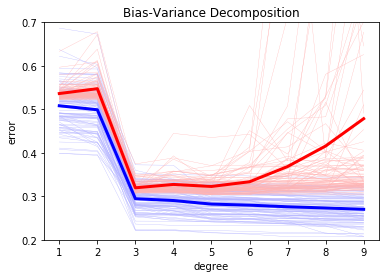

In [16]:
from least_squares import least_squares
from split_data import split_data
from plots import bias_variance_decomposition_visualization

def bias_variance_demo():
    """The entry."""
    # define parameters
    seeds = range(100)
    num_data = 10000
    ratio_train = 0.005
    degrees = range(1, 10)
    
    # define list to store the variable
    rmse_tr = np.empty((len(seeds), len(degrees)))
    rmse_te = np.empty((len(seeds), len(degrees)))
    
    for index_seed, seed in enumerate(seeds):
        np.random.seed(seed)
        x = np.linspace(0.1, 2 * np.pi, num_data)
        y = np.sin(x) + 0.3 * np.random.randn(num_data).T
        # ***************************************************
        # INSERT YOUR CODE HERE
        # split data with a specific seed: TODO
        # ***************************************************
        train_x, train_y, test_x, test_y = split_data(x, y, ratio_train, seed)
        # ***************************************************
        # INSERT YOUR CODE HERE
        # bias_variance_decomposition: TODO
        # ***************************************************
        for degree_index, degree in enumerate(degrees):
            train_tx = build_poly(train_x, degree)
            test_tx = build_poly(test_x, degree)
            train_loss, train_w = least_squares(train_y, train_tx)
            test_loss = compute_mse(test_y, test_tx, train_w)
            rmse_tr_tmp = np.sqrt(2 * train_loss)
            rmse_te_tmp = np.sqrt(2 * test_loss)
            rmse_tr[index_seed, degree_index] = rmse_tr_tmp
            rmse_te[index_seed, degree_index] = rmse_te_tmp
        
    print(rmse_tr.shape, rmse_te.shape)
    bias_variance_decomposition_visualization(degrees, rmse_tr, rmse_te)

bias_variance_demo()